# Pipeline reduction

This is a tutorial about how to use the `zeus2_toolbox` package to read, write, analyze and visualize ZEUS2 data. First we need to import the `zeus2_toolbox.pipeline` module, which already imports all other modules of the package.

In [1]:
from zeus2_toolbox import pipeline as z2pipl

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

## Data reduction on science target

Let's start with the most useful part, which is to reduce some actual data. The first example is to reduce PLCK G244 data taken on 2019/11/28, beam number 0 ~ 39. We begin with loading the array map corresponding to the observation setup.

In [3]:
array_map = z2pipl.ArrayMap.read("/data2/share/zeus-2/ref/array_map_excel_alternative_20211101.csv")
array_map.set_band(350)

Optionally we can also load the observation log which contains lots of supplementary information of the observation. Otherwise set `obs_log = None`.

In [4]:
obs_log = z2pipl.ObsLog.read_folder("/data2/share/zeus-2/all_apex_2019/apex_logs/obslogs")

Besides we will also define some handy variables controlling where to read our data from and where to write the result figure/table.

In [5]:
DATA_DIR = "/data2/share/zeus-2/all_apex_2019/20191128/"
WRITE_DIR = "/data/bp/workspace/zeus-2/nb/Plck_g244+54"

Now we can start actual data reduction. An observation often involves one or multiple flat field scans used as the normalization of the detector. After that, the science observation is taken by the command `zobs` which means nodding the telescope between the neighboring beams to subtract the flux due to telescope dish temperature gradient.

We first need to get the flat field result in the file "skychop_191128_0068" and "skychop_191128_0069". To do that we call `z2pipl.reduce_flat()` function with `flat_header={"skychop_191128": [(68, 69)]}`. The `flat_header` variable indicates the filename of the beams to process, it has the format as `dict{"file_header1": [(start_beam_num1, end_beam_num1), (start_beam_num2, end_beam_num2), ...], ...}`. `flat_header` is designed this way to has the flexibility to combine beams of different file headers, or not continuous.

Because the line is placed at \[1, 11\], we would like to check the timeseries and the performance of the pixels in that region. Therefore we `REG_INTEREST={"spat_ran":(0,2), "spec_ran":(9,13)}` so that the function would plot the time series, beam and beam pair flux of the pixels in the spatial position 0 through 2, spectral index 9 through 13. There are many ways to set `REG_INTEREST` to control the pixels you would like to plot. The variable `ref_interest` is passed to `ArrayMap.take_where()` as `kwargs`, please refer to the document for more information.

In [6]:
FLAT_HEADER = {"skychop_191128": [(68, 69)]}
REG_INTEREST = {"spat_ran":(0, 2), "spec_ran":(9,13)}

In [7]:
flat_result = z2pipl.reduce_skychop(
    flat_header=FLAT_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, parallel=True, return_pix_flag_list=True, table_save=True, 
    plot=True, plot_ts=True, reg_interest=REG_INTEREST,
    plot_flux=True, plot_show=False, plot_save=True)
flat_flux, flat_err, pix_flag_list = flat_result[:2] + flat_result[-1:]

Processing beam /data2/share/zeus-2/all_apex_2019/20191128/skychop_191128_0068.
Processing beam /data2/share/zeus-2/all_apex_2019/20191128/skychop_191128_0069.


Because I set `table_save=True, plot_show=False, plot_save=True`, the tables and figures containing the result can be checked in the set `WRITE_DIR`. It is not recommended to set `plot_show=True` as it would take extra time for jupyter to display the figure (minutes if the figure is big) and slow down the reduction process. We then proceed to the next step of reducing the science data. Following a similar logic, we call `z2pipl.reduce_zobs()` function with `data_header={"plck_191128": [(0, 39)]}` to reduce data stored in files "plck_191128_0000" through "plck_191128_0039". And we only use "desnake" to reduce the long term noise in the timeseries. The line pixel \[1, 11\] is used as the reference pixel to select other good pixels, which are averaged together to build a high SNR snake model.

In [8]:
DATA_HEADER = {"plck_191128": [(0, 39)]}
REF_PIX = [1, 11]

In [ ]:
zobs_result = z2pipl.reduce_zobs(
    data_header=DATA_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, pix_flag_list=pix_flag_list,
    flat_flux=flat_flux, flat_err=flat_err, parallel=True, stack=False,
    do_desnake=True, ref_pix=REF_PIX, do_smooth=False, 
    do_ica=False, spat_excl=None, return_ts=False, 
    return_pix_flag_list=True, table_save=False, plot=True, plot_ts=True,
    reg_interest=REG_INTEREST, plot_flux=True, 
    plot_show=False, plot_save=True, analyze=True)
zobs_flux, zobs_err, zobs_pix_flag_list = zobs_result[:2] + zobs_result[-1:]

Let's check the spectrum of the observation

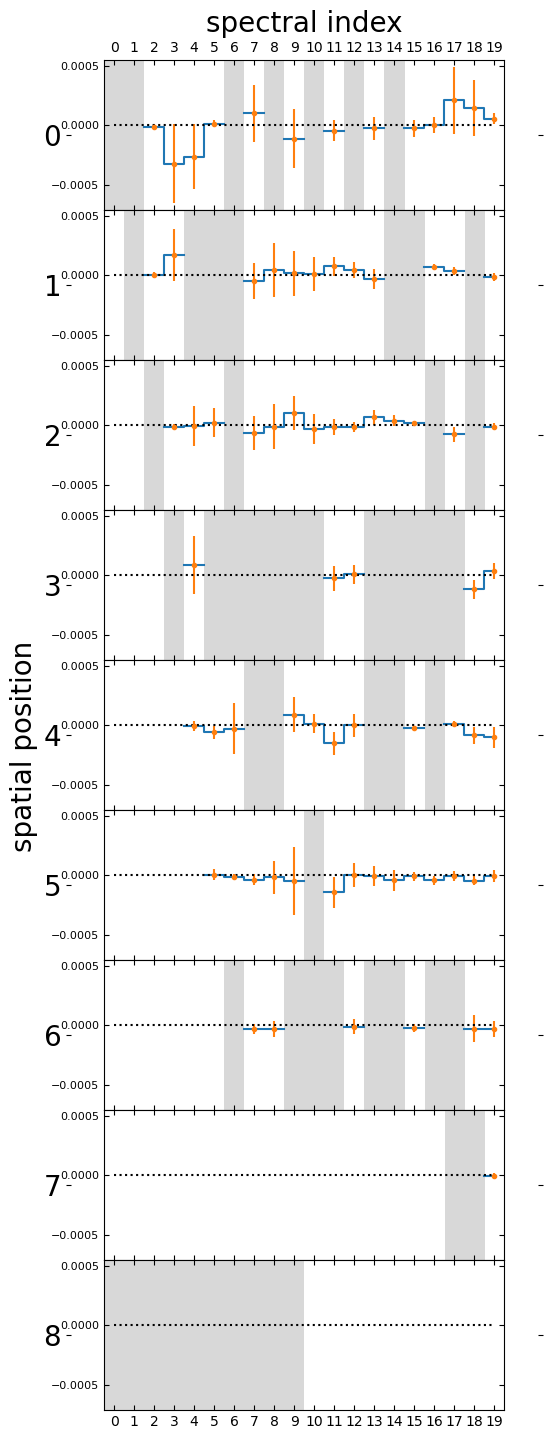

In [10]:
fig = z2pipl.FigSpec.plot_spec(zobs_flux, yerr=zobs_err, 
                               pix_flag_list=zobs_pix_flag_list)
fig.plot_all_spat([0, 19], [0, 0], ls=":", c="k")
plt.show(fig)

Now let's try to use ICA decomposition to reduce the correlated noise. Remember to set `stack=True` to stack beams of opposite nodding phase to exclude flux due to temperature gradient. Also remember to set `spat_excl` as the spatial position excluded from ICA decomposition. In this case it is set to `[0, 2]` as the potential spatial position of the target.

In [11]:
SPAT_EXCL = [0, 2]

In [ ]:
zobs_ica_result = z2pipl.reduce_zobs(
    data_header=DATA_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, pix_flag_list=pix_flag_list,
    flat_flux=flat_flux, flat_err=flat_err, parallel=True, stack=True,
    do_desnake=False, ref_pix=REF_PIX, do_smooth=False, 
    do_ica=True, spat_excl=SPAT_EXCL, return_ts=False, 
    return_pix_flag_list=True, table_save=False, plot=True, plot_ts=True,
    reg_interest=REG_INTEREST, plot_flux=True, 
    plot_show=False, plot_save=True, analyze=True)
zobs_ica_flux, zobs_ica_err, zobs_ica_pix_flag_list = zobs_ica_result[:2] + zobs_ica_result[-1:]

We can compare with result of the two reductions. 

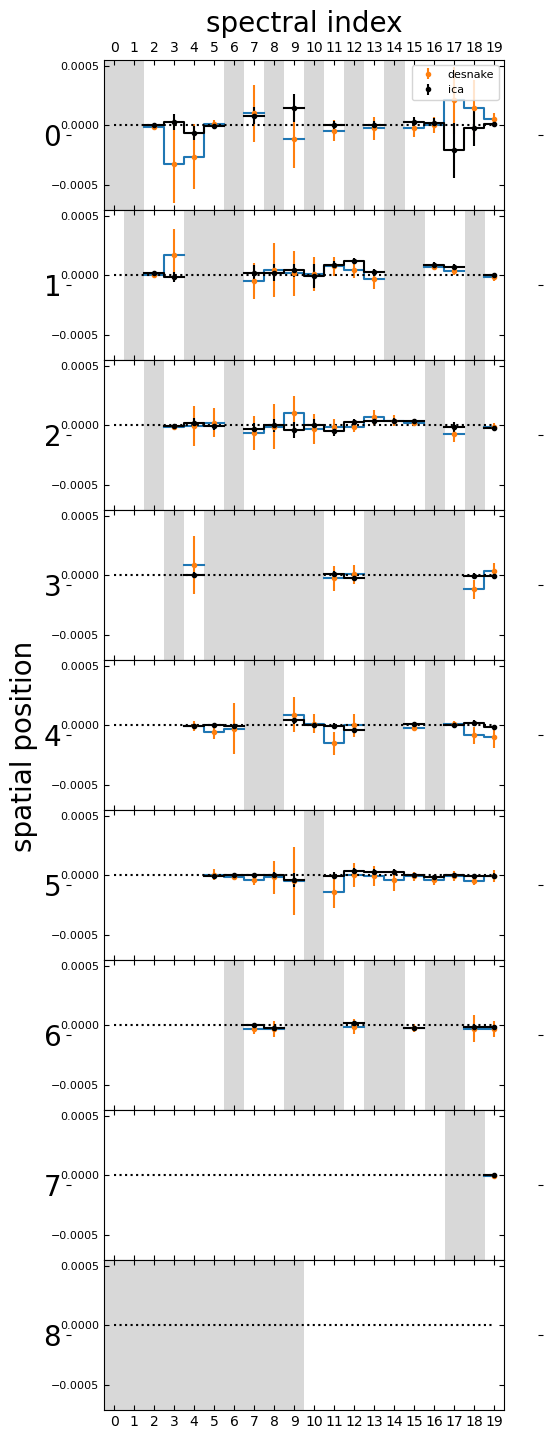

In [13]:
fig = z2pipl.FigSpec.plot_spec(zobs_flux, yerr=zobs_err, 
                               pix_flag_list=zobs_pix_flag_list, label="desnake")
fig.step(zobs_ica_flux, pix_flag_list=zobs_pix_flag_list, c="k")
fig.errorbar(zobs_ica_flux, yerr=zobs_ica_err, pix_flag_list=zobs_pix_flag_list, 
             color="k", label="ica")
fig.plot_all_spat([0, 19], [0, 0], ls=":", color="k")
fig.legend()
plt.show(fig)

The flux of each beam pair (black) and the convergence of cumulative flux (cyan) is presented in the "{header}\_beam\_pairs\_flux.png". The black data point with errorbar represents the flux of pixel in each beam pair, with the cyan point showing the cumulative flux throughout the integration. The value of the data points are in the y-axis on the left side. The red dash line corresponding to the right y-axis is the PWV along the time.

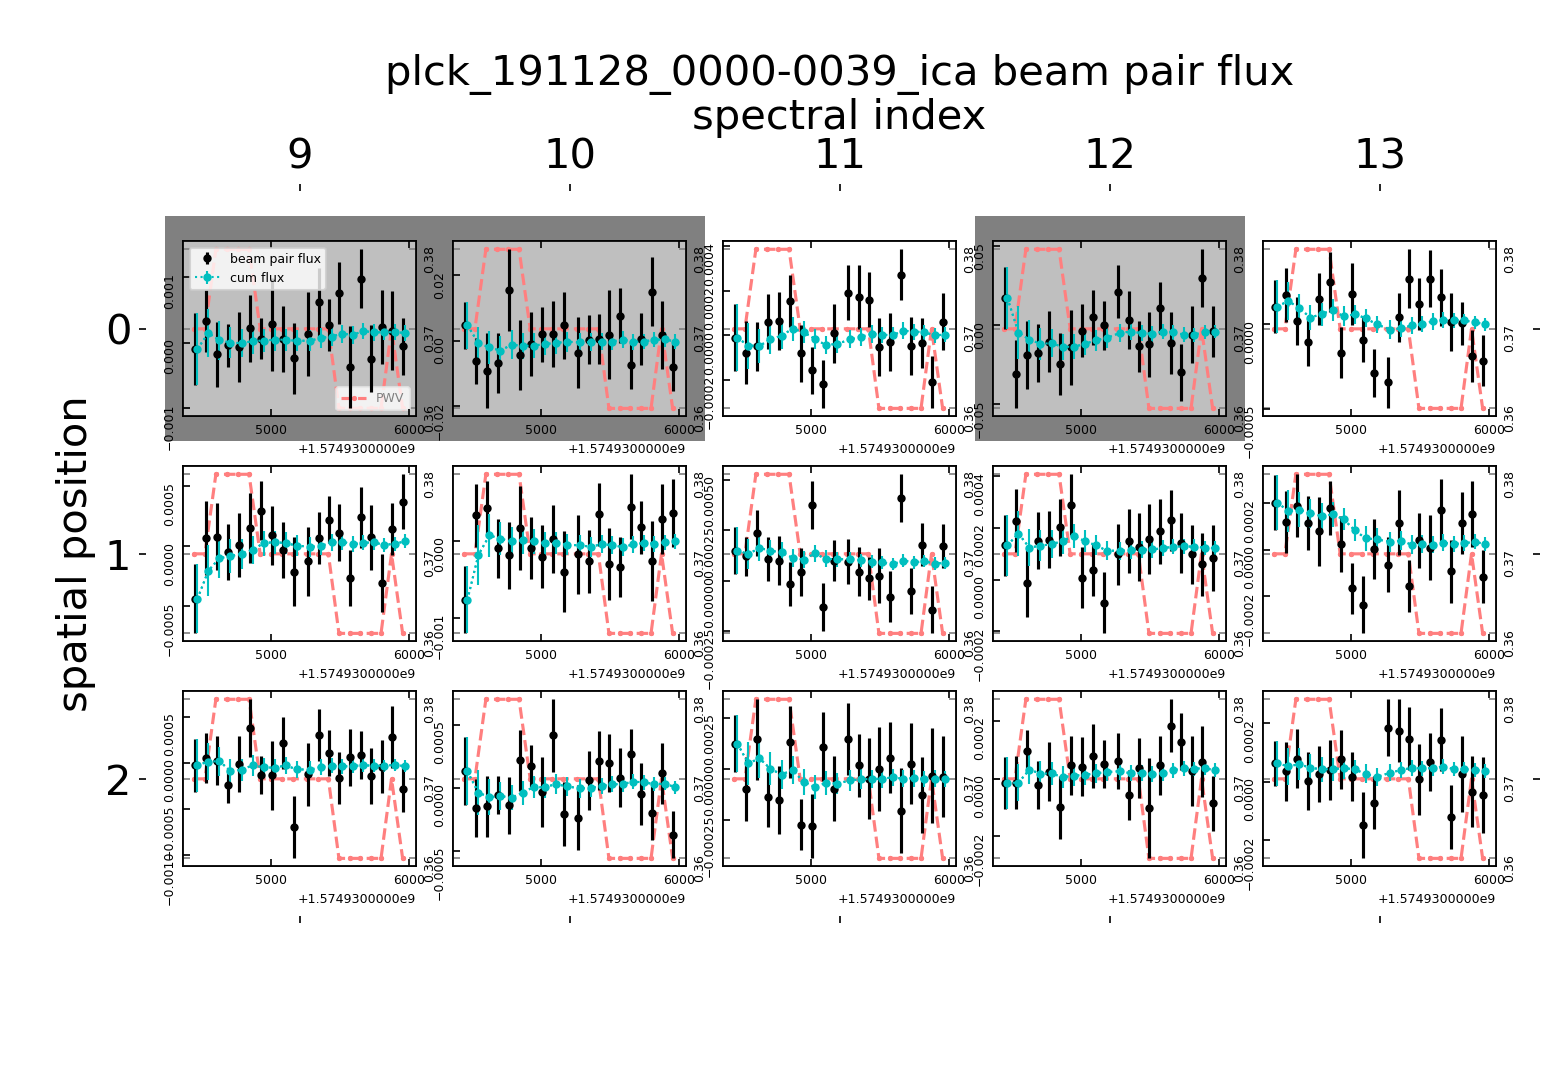

In [14]:
Image(os.path.join(WRITE_DIR, "plck_191128_0000-0039_ica_beam_pairs_flux.png"))

We can also compare the power spectrum and dynamical spectrum after desnaking and ICA decomposition, it can be seen that correlated noise is suppressed significantly after ICA.

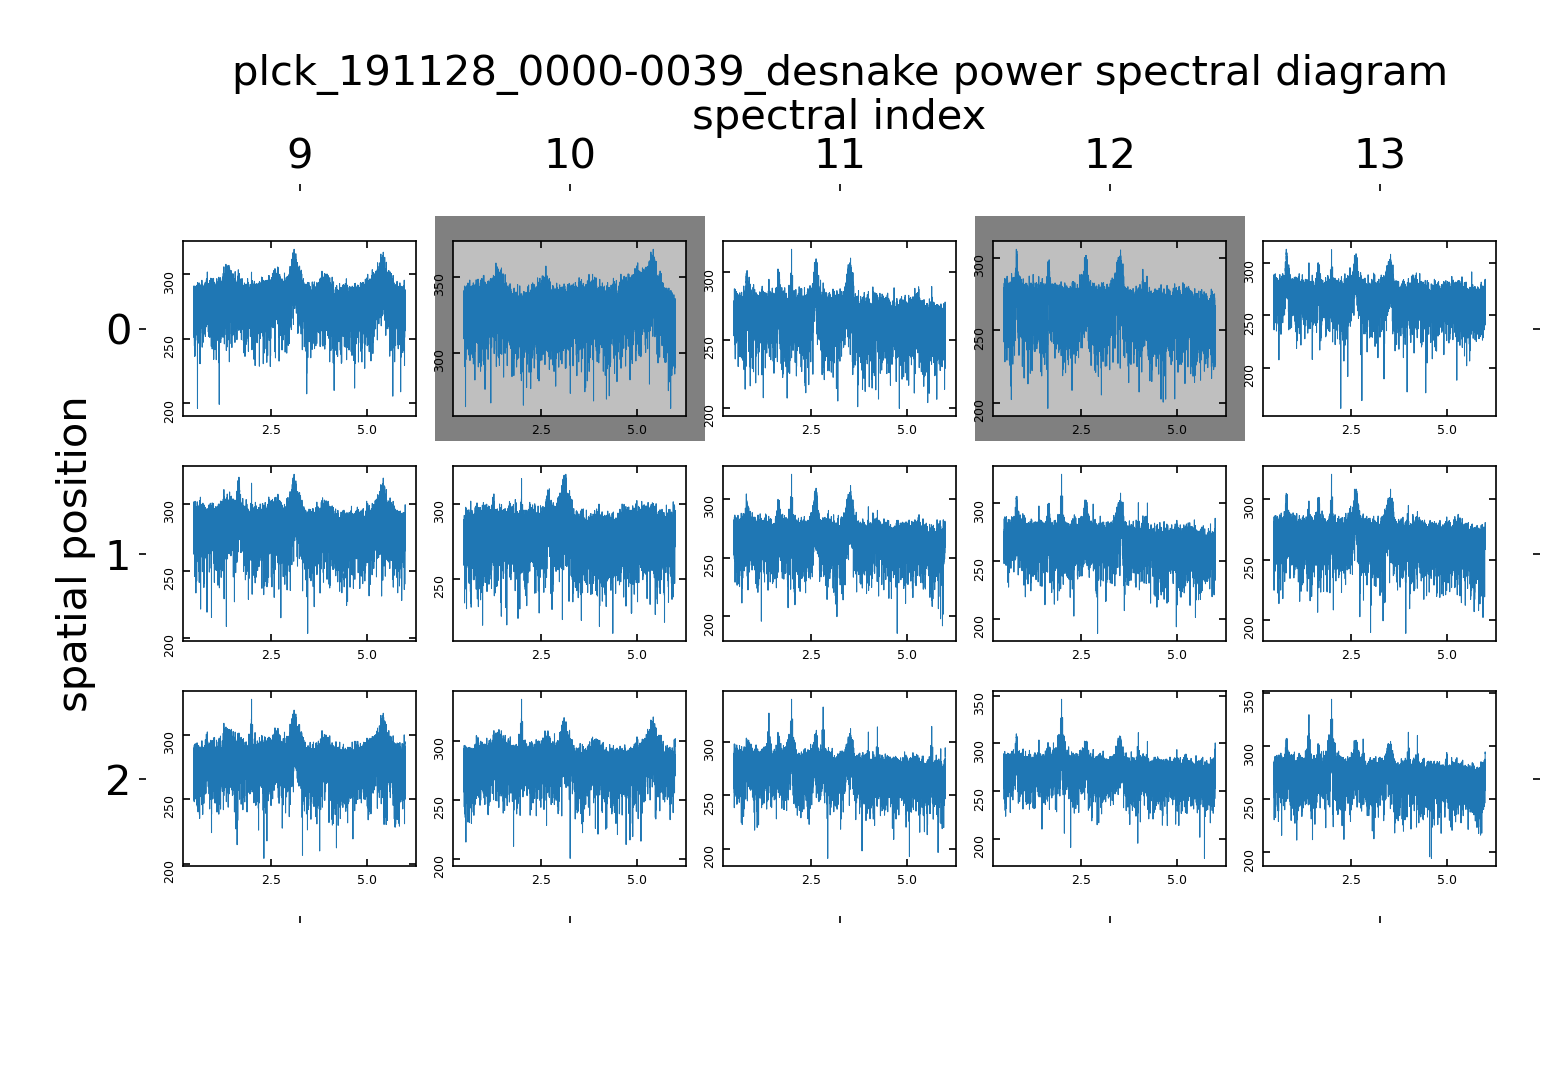

In [15]:
Image(os.path.join(WRITE_DIR, "plck_191128_0000-0039_desnake_psd.png"))

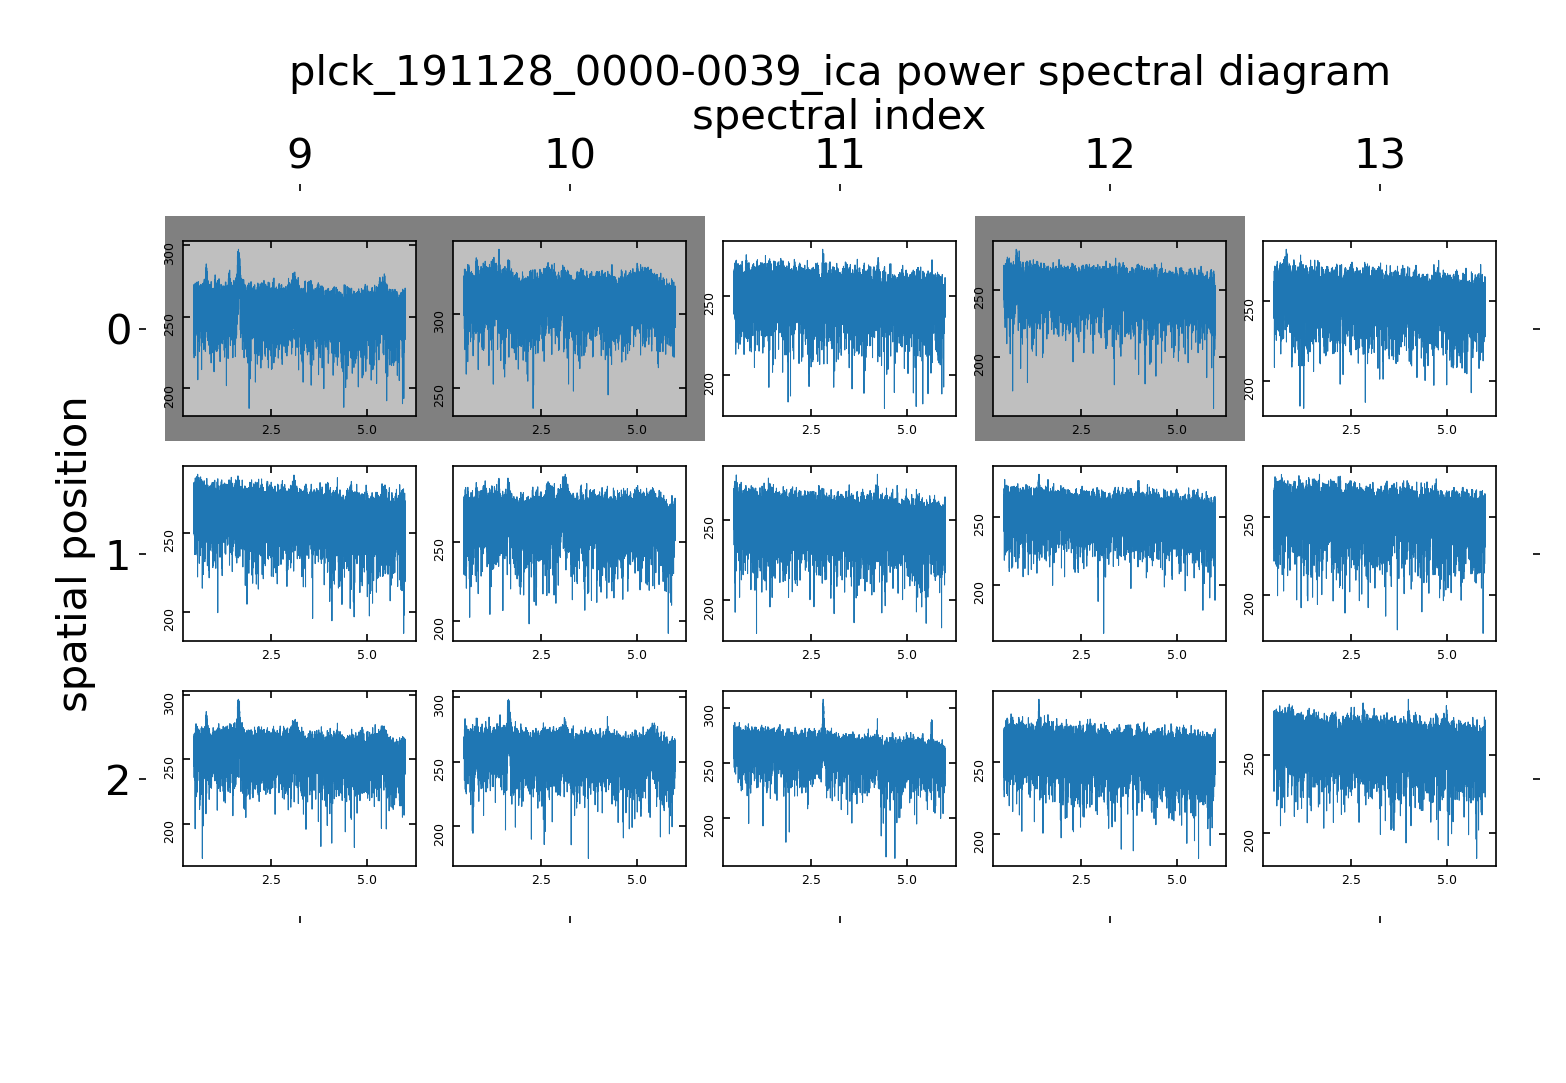

In [16]:
Image(os.path.join(WRITE_DIR, "plck_191128_0000-0039_ica_psd.png"))

For the convenience I show another example with a single block of code that reduces w0533_191130_0084-0143 with ICA. I will not read array map or observation log again.

In [ ]:
DATA_DIR = "/data2/share/zeus-2/all_apex_2019/20191130/" 
WRITE_DIR = "/data/bp/workspace/zeus-2/nb/W0533-3401"

FLAT_HEADER = {"skychop_191130": [(24, 26)]}
DATA_HEADER = {"w0533_191130": [(84, 143)]}

# reduction method
DO_DESNAKE, REF_PIX = False, None
DO_SMOOTH = False
DO_ICA, SPAT_EXCL = True, [0, 2]

# flag
PARALLEL = True
TABLE_SAVE = True
PLOT = True
PLOT_TS = True  # can slow down reduction significantly
REG_INTEREST = {"spat_ran":(0, 2), "spec_ran":(5, 9)} # line is placed at [1, 7]
PLOT_FLUX = True
PLOT_SHOW = False
PLOT_SAVE = True
ANALYZE = True  # can slow down reduction significantly

# reduce flat
flat_result = z2pipl.reduce_skychop(
    flat_header=FLAT_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, parallel=PARALLEL, 
    table_save=TABLE_SAVE, plot=PLOT, plot_ts=PLOT_TS, reg_interest=REG_INTEREST,
    plot_flux=PLOT_FLUX, plot_show=PLOT_SHOW, plot_save=PLOT_SAVE)
flat_flux, flat_err, pix_flag_list = flat_result[:2] + flat_result[-1:]

# reduce zobs
zobs_ica_result = z2pipl.reduce_zobs(
    data_header=DATA_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, pix_flag_list=pix_flag_list,
    flat_flux=flat_flux, flat_err=flat_err, parallel=PARALLEL, stack=DO_ICA,
    do_desnake=DO_DESNAKE, ref_pix=REF_PIX, do_smooth=DO_SMOOTH, 
    do_ica=DO_ICA, spat_excl=SPAT_EXCL, return_pix_flag_list=True, 
    table_save=TABLE_SAVE, plot=PLOT, plot_ts=PLOT_TS,
    reg_interest=REG_INTEREST, plot_flux=PLOT_FLUX, 
    plot_show=PLOT_SHOW, plot_save=PLOT_SAVE, analyze=ANALYZE)
zobs_ica_flux, zobs_ica_err, zobs_ica_pix_flag_list = zobs_ica_result[:2] + zobs_ica_result[-1:]

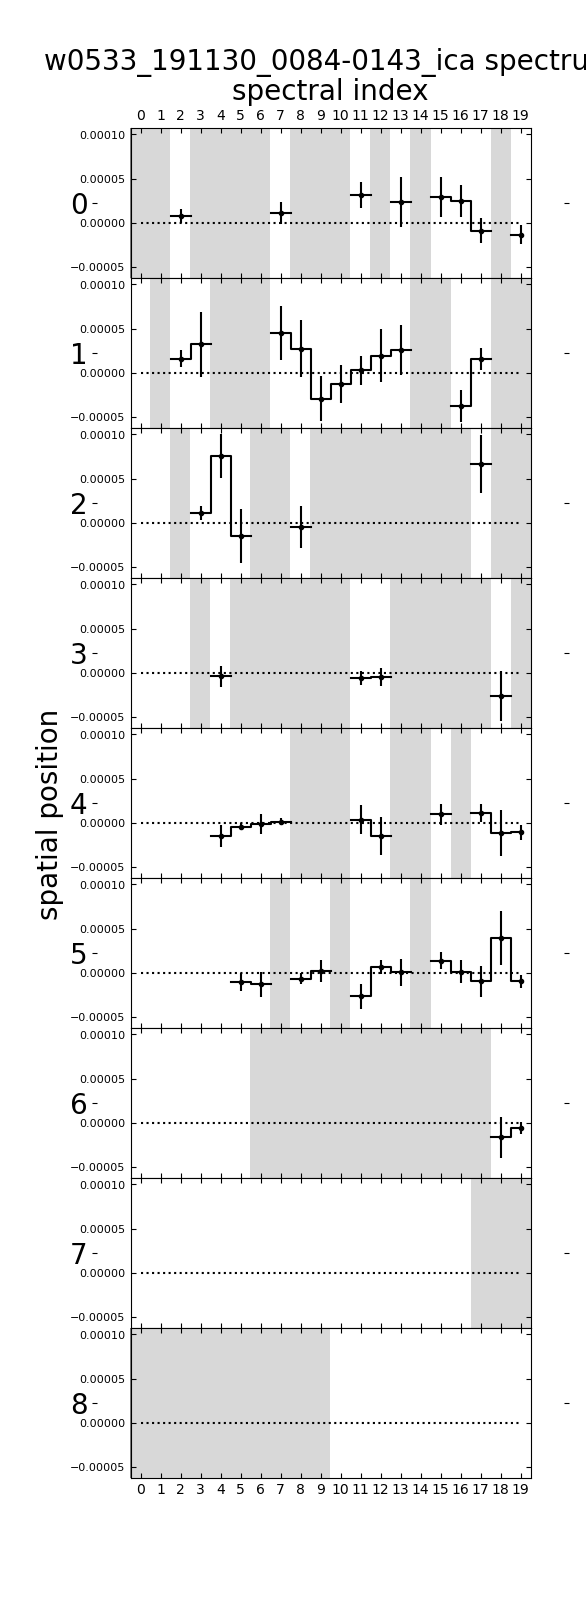

In [18]:
Image(os.path.join(WRITE_DIR, "%s_ica_spec.png" % z2pipl.build_header(DATA_HEADER)))

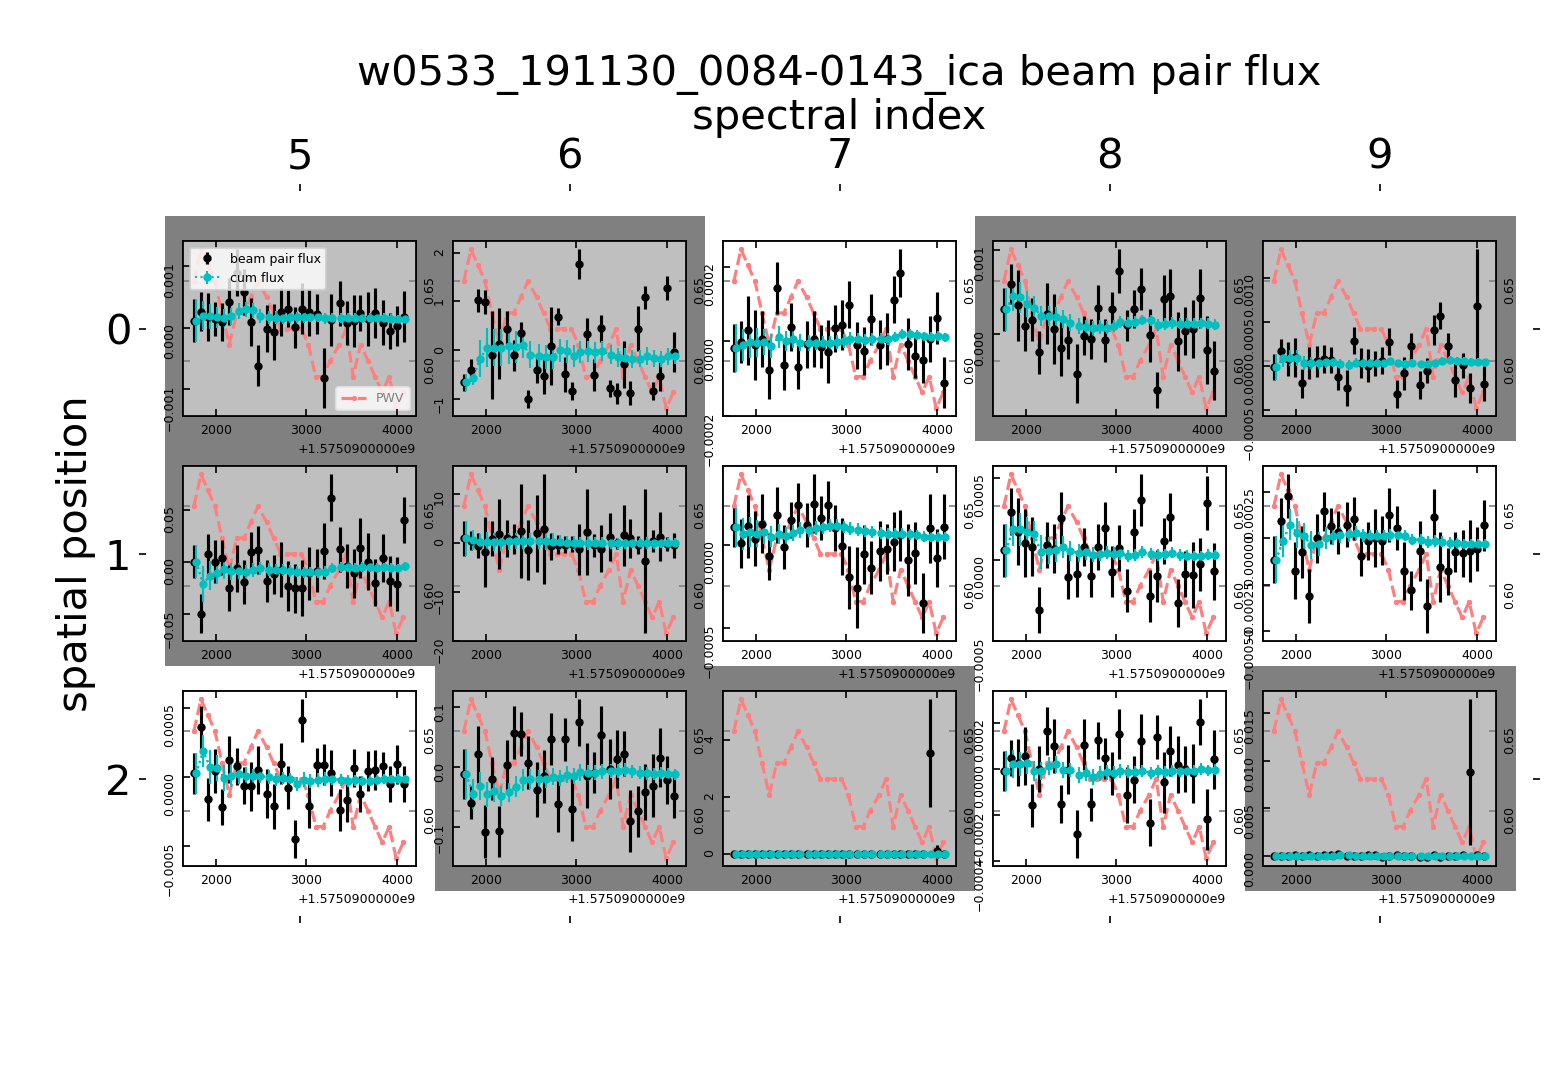

In [19]:
Image(os.path.join(WRITE_DIR, "%s_ica_beam_pairs_flux.png" % z2pipl.build_header(DATA_HEADER)))

## Data reduction on calibration source

All observations taken with the commands other than `zobs`, `zpold` and `zpoldbig` are just continuous beams without nodding or special ordering. Most of the information is in the flux variation in different beams. Here for example, let's reduce uranus_191128 beam 26 through 36, which is an `zpoint` observation for that night. Because this scan doesn't have a skychop, we will skip the flat reduction step and leave the default value for flat, which are `flat_flux=1` and `flat_err=0`. Because the line is put at [1, 6], we would like to plot the spatial range [0, 2] and spectral range [5, 9].

In [ ]:
DATA_DIR = "/data2/share/zeus-2/all_apex_2019/20191128/" 
WRITE_DIR = "/data/bp/workspace/zeus-2/nb/test"


DATA_HEADER = {"skychop_191128": [(26, 36)]}

# reduction method
DO_DESNAKE, REF_PIX = False, None
DO_SMOOTH = False
DO_ICA, SPAT_EXCL = False, None

# flag
PARALLEL = True
TABLE_SAVE = True
PLOT = True
PLOT_TS = True
REG_INTEREST = {"spat_ran":(0, 2), "spec_ran":(5, 9)} # line is placed at [1, 6]
PLOT_FLUX = True
PLOT_SHOW = False
PLOT_SAVE = True
ANALYZE = True  # can slow down reduction significantly

flat_flux, flat_err = 1, 0

# reduce zobs
zpoint_result = z2pipl.reduce_calibration(
    data_header=DATA_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, pix_flag_list=[],
    flat_flux=flat_flux, flat_err=flat_err, parallel=PARALLEL, 
    do_desnake=DO_DESNAKE, ref_pix=REF_PIX, do_smooth=DO_SMOOTH, 
    do_ica=DO_ICA, spat_excl=SPAT_EXCL, return_pix_flag_list=True, 
    table_save=TABLE_SAVE, plot=PLOT, plot_ts=PLOT_TS,
    reg_interest=REG_INTEREST, plot_flux=PLOT_FLUX, 
    plot_show=PLOT_SHOW, plot_save=PLOT_SAVE, analyze=ANALYZE)
zpoint_flux, zpoint_err, zpoint_pix_flag_list = zpoint_result[:2] + zpoint_result[-1:]

The figure below shows the pixel flux of each beam in the raw data unit due to the lack of skychop.

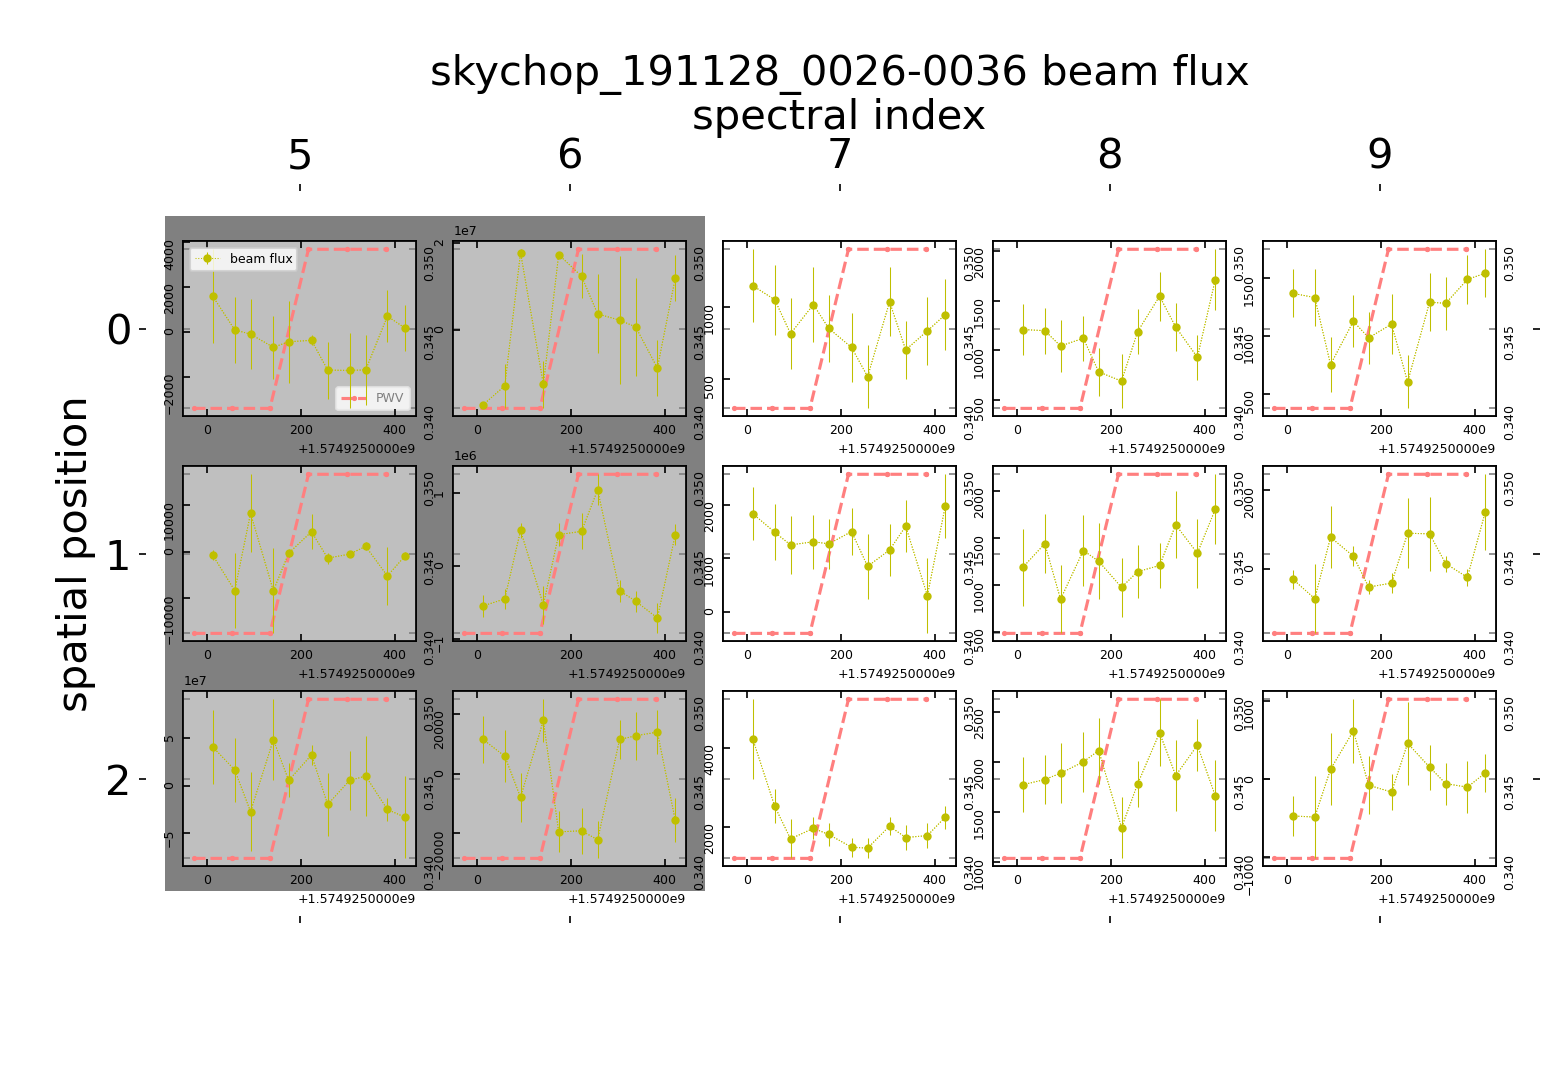

In [21]:
Image(os.path.join(WRITE_DIR, "%s_beams_flux.png" % z2pipl.build_header(DATA_HEADER)))

## Reduction of zpold or zpoldbig raster

For the purpose of checking focus/pointing quality, a raster of 3x3 or 5x5 size is taken by observing 9 or 25 beams while moving the telescope. The raster starts on the lower left corner, scanning horizontally to the right, then zigzaging upwards. The `reduce_zpold()` and `reduce_zpoldbig()` functions are developed to reduce these data and produce a figure representing the raster seen by each pixel.

As an example, I will show uranus_191126_0025 to 0049 taken with `zpoldbig`. The flat is skychop_191126 260 through 262. I would like to see the raster on the whole 400 micron array, so I will read in the aray map again with the band set to 400 instead of 350.

In [22]:
array_map = z2pipl.ArrayMap.read("/data2/share/zeus-2/ref/array_map_excel_alternative_20211101.csv")
array_map.set_band(400)

In [ ]:
DATA_DIR = "/data2/share/zeus-2/all_apex_2019/20191126" 
WRITE_DIR = "/data/bp/workspace/zeus-2/nb/Uranus"

FLAT_HEADER = {"skychop_191126": [(260, 262)]}
DATA_HEADER = {"uranus_191126": [(25, 49)]}

# reduction method
DO_DESNAKE, REF_PIX = False, None
DO_SMOOTH = False
DO_ICA, SPAT_EXCL = False, None

# flag
PARALLEL = True
TABLE_SAVE = True
PLOT = True
PLOT_TS = False # pltting the time series of all the pixels can be very slow
REG_INTEREST = None # show the whole array
PLOT_FLUX = True
PLOT_SHOW = False
PLOT_SAVE = True
ANALYZE = False  # to accelerate reduction

# reduce flat
flat_result = z2pipl.reduce_skychop(
    flat_header=FLAT_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, parallel=PARALLEL, 
    table_save=TABLE_SAVE, plot=PLOT, plot_ts=PLOT_TS, reg_interest=REG_INTEREST,
    plot_flux=PLOT_FLUX, plot_show=PLOT_SHOW, plot_save=PLOT_SAVE)
flat_flux, flat_err, pix_flag_list = flat_result[:2] + flat_result[-1:]

# reduce zobs
zpoldbig_result = z2pipl.reduce_zpoldbig(
    data_header=DATA_HEADER, data_dir=DATA_DIR, write_dir=WRITE_DIR,
    array_map=array_map, obs_log=obs_log, pix_flag_list=pix_flag_list,
    flat_flux=flat_flux, flat_err=flat_err, parallel=PARALLEL,
    do_desnake=DO_DESNAKE, ref_pix=REF_PIX, do_smooth=DO_SMOOTH, 
    do_ica=DO_ICA, spat_excl=SPAT_EXCL, return_pix_flag_list=True, 
    table_save=TABLE_SAVE, plot=PLOT, plot_ts=PLOT_TS,
    reg_interest=REG_INTEREST, plot_flux=PLOT_FLUX, 
    plot_show=PLOT_SHOW, plot_save=PLOT_SAVE, analyze=ANALYZE)
zpoldbig_flux, zpoldbig_err, zpoldbig_pix_flag_list = zpoldbig_result[:2] + zpoldbig_result[-1:]

The result is saved in "{data_header}\_raster.png". In the figure, all the pixels without any 2-sigma detection in any beam are flagged. The pointing target Uranus clearly shows up as a point source at different location for pixels at different spatial position. It also shows the alignment of the array on the sky.

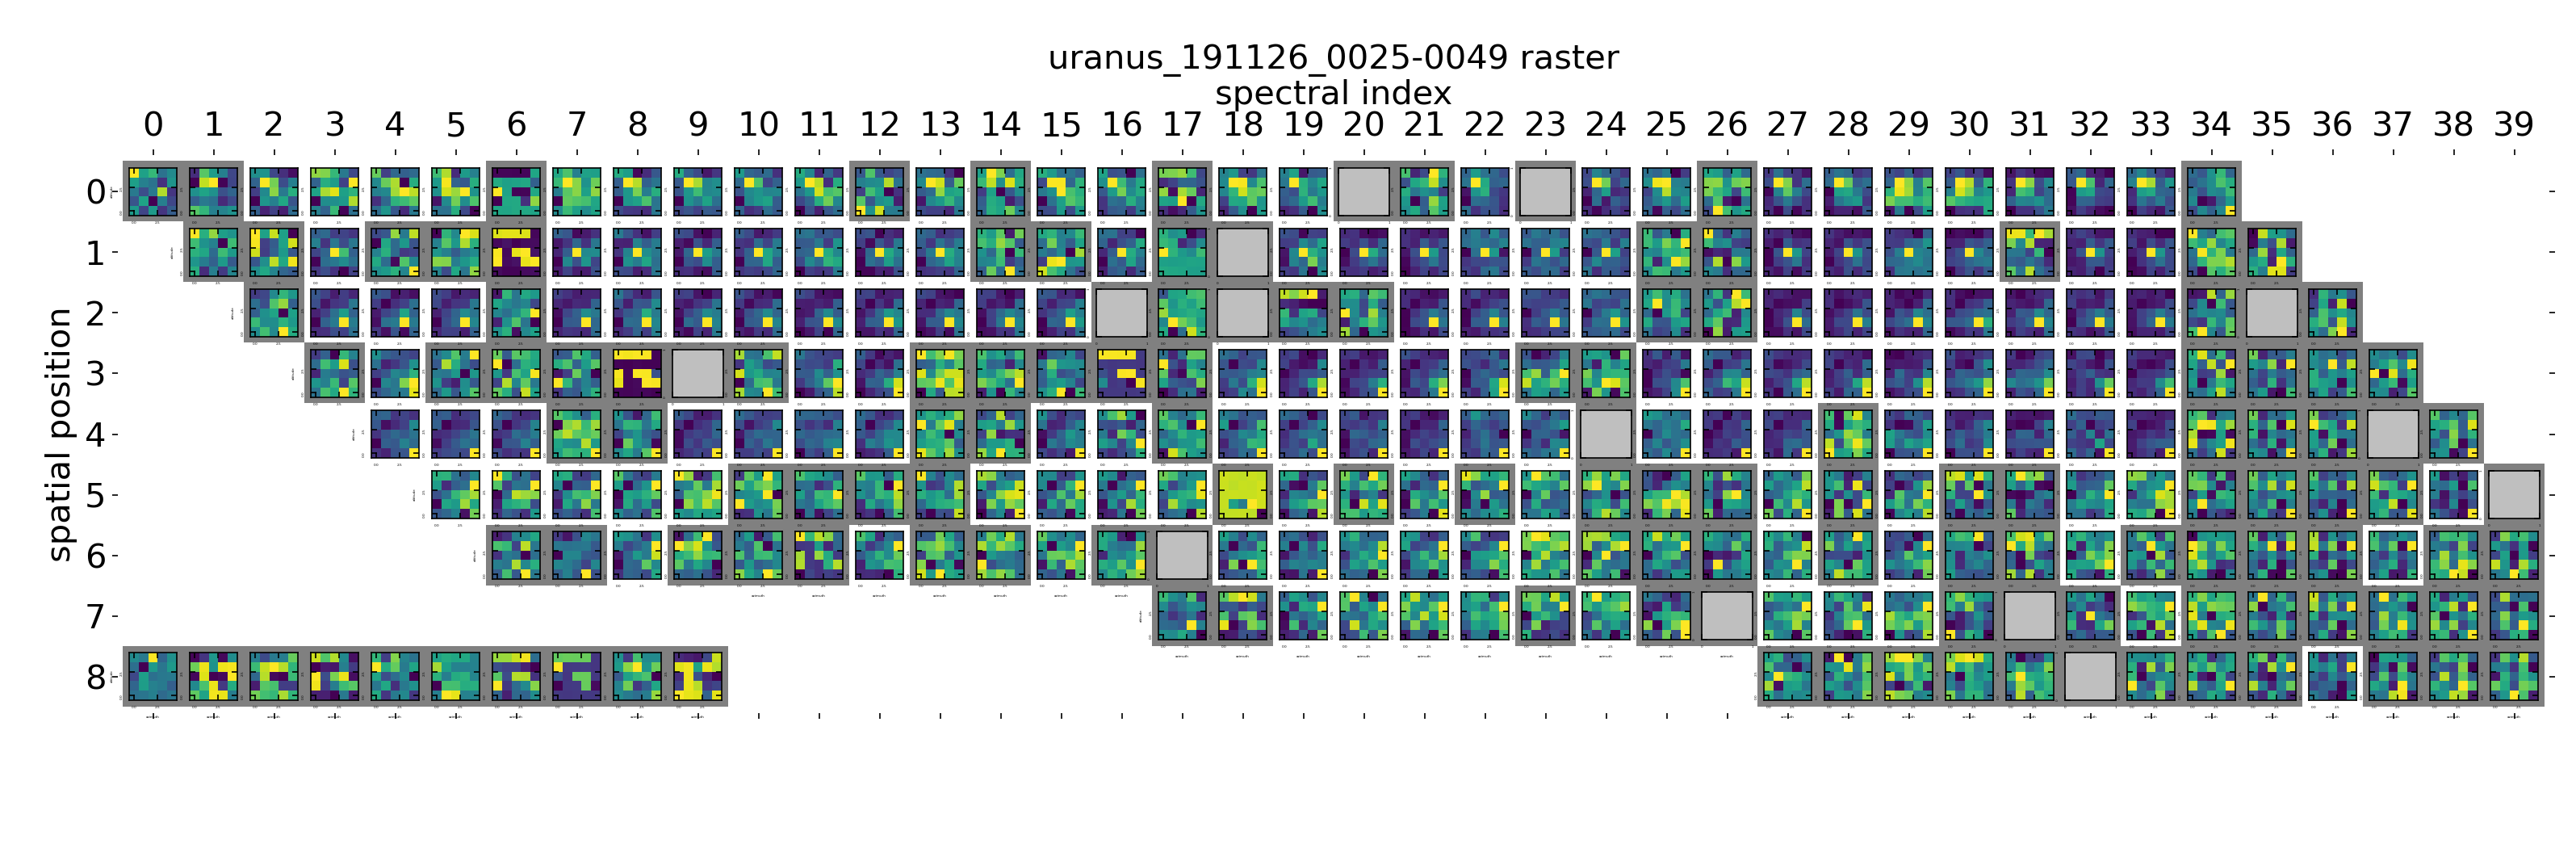

In [24]:
Image(os.path.join(WRITE_DIR, "%s_raster.png" % z2pipl.build_header(DATA_HEADER)))